In [7]:
from pydantic import BaseModel, Field
from langgraph.graph import START, END, StateGraph
from typing import List, TypedDict
from typing_extensions import Annotated
from operator import add
from langchain_mistralai import ChatMistralAI
from langchain_tavily import TavilySearch
from datetime import datetime
from dotenv import load_dotenv

load_dotenv()

class TopicInfo(BaseModel):
    """Information about a user-suggested article topic"""
    topic: str = Field(description="Article topic, extracted exclusively from the user's query or specified from search results.")
    is_topic_complete: bool = Field(description="Boolean indicator of whether or not the currently selected article topic is complete. For example, topics like 'Nature' or 'Technology' are too broad and vague for an article, but 'Top hiking destinations of Europe' and 'Useful prompt engineering techniques' are just right, making them complete.", enum=[True, False])

class TopicQuery(BaseModel):
    queries: List[str] = Field(description="Effective search queries for specifying a broad article topic. For example, for the unspecified article topic 'USA politics', the following queries can be useful: ['USA internal politics', 'USA foreign politics', 'USA history']")

class MaterialInfo(BaseModel):
    material: List[str] = Field(description="Relevant information regarding the specified article topic. Make sure you only include dry facts (bullet points).")
    is_material_complete: bool = Field(description="Boolean indicator of whether or not the material gathered so far is enough for an article. Make sure to only gather the right amount of relevant information: for example, for query 'Current weather', you don't want to include facts about weather definition and usefullness.", enum=[True, False])

class MaterialQuery(BaseModel):
    queries: List[str] = Field(description=f"Effective search queries for finding information relevant (as of the current date: {datetime.now().strftime('%B %Y')}) to the specified article topic. For example, for the 'USA foreign politics' topic, the following queries can be useful: ['USA current president', 'USA allies', 'USA conflicts'].")



class ArticleBlock(BaseModel):
    heading: str = Field(description="Heading of one of the article's subsections")
    content: str = Field(description="Content of the subsection.")

class ArticlePlan(BaseModel):
    """Article structure, containing each subsection's heading and the facts that it should contain, discuss or deduce."""
    blocks: List[ArticleBlock] = Field(desciption="List of subsections.")

class Article(BaseModel):
    heading: str = Field(description="Article intriguing heading, reflecting its topic and the message that it is trying to convey")
    blocks: List[ArticleBlock] = Field(desciption="List of subsections.")

class State(TypedDict):
    query: str
    topic: str
    is_topic_complete: bool
    material: Annotated[List[str], add]
    is_material_complete: bool
    plan: ArticlePlan
    article: Article

llm = ChatMistralAI(model="mistral-large-latest")
search = TavilySearch(max_results=2)

def generate_plan(state: State):
    plan_llm = llm.with_structured_output(ArticlePlan)
    prompt = f"""
    Generate an article structure based on its topic and content desciption.
    Make sure to plan the article size properly: for topic 'Current weather in California' 3 subsections is too long, and for topic 'Technological advancement prediction for 2027' even 5 subsections is, probably, too short.
    Article topic: {state['topic']}
    Bullet points:
    {'\n'.join(state['material'])}
    """
    plan = plan_llm.invoke(prompt)
    return {"plan": plan}

def write_article(state: State):
    writer_llm = llm.with_structured_output(Article)
    headings = []
    content = []
    for section in state['plan'].blocks:
        headings.append(section.heading)
        content.append(section.content)

    prompt = f"""
    You are a professional young journalist. Write an engaging article given its desciption, following the provided structure. You're free to rename subsections headers for stronger reflection of their content.
    Try to be as exact as possible, avoid vagueness and ambiguity: your job is to present dry facts and wrap them in your commentary, not the other way around.
    Article topic: {state['topic']}
    Bullet points:
    {'\n'.join(state['material'])}
    Article structure:
    {'\n\n'.join([heading+'\n'+content for heading, content in zip(headings, content)])}
    """

    article = writer_llm.invoke(prompt)
    return {"article": article}

def specify_topic(state: State):
    query_llm = llm.with_structured_output(TopicQuery)
    topic_llm = llm.with_structured_output(TopicInfo)

    queries = query_llm.invoke(state.get('topic', state['query'])).queries
    results = []
    for query in queries:
        found = search.invoke(query)['results']
        results.extend([res['title']+'\n'+res['content'] for res in found])

    prompt = f"""
    You are currently trying to specify the following article topic: {state.get('topic', state['query'])}. 
    If you think that the original topic is not too broad and is on-point for an article, leave it as is. Else, specify it using the provided search results. Make sure your choice aligns with the original query.
    Search results:
    - {'\n\n'.join(results)}
    """
    info = topic_llm.invoke(prompt)
    return {"topic": info.topic, "is_topic_complete": info.is_topic_complete}

def gather_material(state: State):
    query_llm = llm.with_structured_output(MaterialQuery)
    material_llm = llm.with_structured_output(MaterialInfo)

    prompt = f"""
    Given an article topic and the currently gathered relevant information on the matter, try to come up with search queries that would help you find additional facts.
    Topic: {state['topic']}
    Currently found material:
    {'\n'.join(state['material']) if 'material' in state else 'Nothing found yet'}
    """
    queries = query_llm.invoke(prompt).queries
    results = []
    for query in queries:
        found = search.invoke(query)['results']
        results.extend([res['title']+'\n'+res['content'] for res in found])

    prompt = f"""
    You are currently trying to gather some relevant material to write an article on the following topic: {state['topic']}. Extract some dry facts out of the following search results and decide if it's enough or one would need more information to cover this matter.
    Search results:
    - {'\n\n'.join(results)}
    """
    info = material_llm.invoke(prompt)
    return {"material": info.material, "is_material_complete": info.is_material_complete}

def condition(state: State):
    print(state)
    if not state['is_topic_complete']:
        return 'specify_topic'
    if not state['is_material_complete']:
        return 'gather_material'
    return 'generate_plan'

def router(state: State):
    if not 'is_topic_complete' in state and not 'is_material_complete' in state:
        return {'is_topic_complete': False, 'is_material_complete': False}


workflow = StateGraph(State)

workflow.add_node('generate_plan', generate_plan)
workflow.add_node('write_article', write_article)
workflow.add_node('specify_topic', specify_topic)
workflow.add_node('gather_material', gather_material)
workflow.add_node('router', router)

workflow.add_edge(START, 'router')
workflow.add_conditional_edges(
    'router', 
    condition,
    {'specify_topic': 'specify_topic',
     'gather_material': 'gather_material',
     'generate_plan': 'generate_plan'}
)

workflow.add_edge('specify_topic', 'router')
workflow.add_edge('gather_material', 'router')
workflow.add_edge('generate_plan', 'write_article')
workflow.add_edge('write_article', END)

app = workflow.compile()


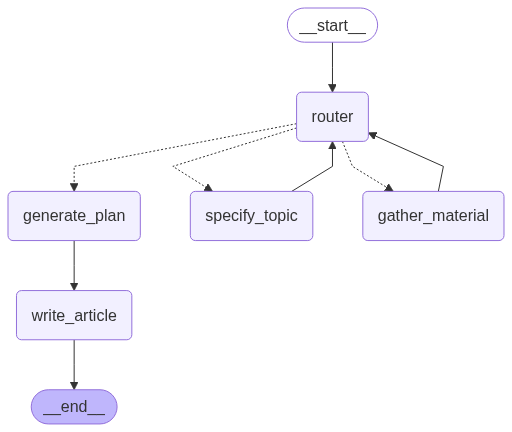

In [8]:
app

In [12]:
article = app.invoke({"query": "какая погода сейчас в перми"})

{'query': 'какая погода сейчас в перми', 'is_topic_complete': False, 'material': [], 'is_material_complete': False}
{'query': 'какая погода сейчас в перми', 'topic': 'Текущая погода в Перми: температура, осадки и ветер', 'is_topic_complete': True, 'material': [], 'is_material_complete': False}
{'query': 'какая погода сейчас в перми', 'topic': 'Текущая погода в Перми: температура, осадки и ветер', 'is_topic_complete': True, 'material': ['Текущая погода в Перми сегодня пасмурная и теплая.', 'Температура днём: от +13 до +23 °C, ночью до +14 °C.', 'Утром: +16 °C, пасмурно, ощущается как +16 °C.', 'Днём: +22 °C, облачно с прояснениями, ощущается как +22 °C.', 'Вечером: +19 °C, дождь с грозой, ощущается как +18 °C.', 'Ветер: лёгкий бриз, скорость 1–3 м/с, порывы до 8 м/с.', 'Направление ветра: юго-восточное, восточное.', 'Осадки: небольшой дождь, местами дождь с грозой.', 'Относительная влажность воздуха: 67–99%.', 'Атмосферное давление: 736–739 мм рт. ст.', 'Облачность: 100%, туман.', 'УФ-и

In [10]:
def print_article(article: Article):
    print(article.heading)
    print('\n')
    for block in article.blocks:
        print(block.heading)
        print(block.content)
        print()

In [13]:
print_article(article['article'])

Текущая погода в Перми: тепло, пасмурно и переменчиво


Общий обзор погоды: что сегодня ждёт пермяков?
Сегодняшний день в Перми встречает жителей пасмурной, но тёплой погодой. Несмотря на облачность, температура воздуха остаётся комфортной для прогулок и активного отдыха. Однако переменчивые атмосферные явления, такие как дождь и гроза, могут внести свои коррективы в планы горожан. Основные характеристики погоды сегодня — это умеренный ветер, высокая влажность и нестабильное атмосферное давление.

Температурный режим: от утра до вечера
Утро в Перми началось с пасмурной погоды и температуры +16 °C, которая ощущается именно так, как показывает термометр. Днём воздух прогреется до +22 °C, а облачность местами будет разбавляться прояснениями. Ощущаемая температура останется равной фактической, что создаст комфортные условия для пребывания на улице. К вечеру столбик термометра опустится до +19 °C, но из-за дождя с грозой будет казаться, что на улице +18 °C. Температура воды в местных водоём

In [ ]:
import nest_asyncio
import os
nest_asyncio.apply()

def get_output(query: str):
    article = app.invoke({"query": query})['article']
    res = ''
    res += article.heading + '\n\n\n'
    for block in article.blocks:
        res += block.heading + '\n'
        res += block.content + '\n\n'
    return res

from telegram import Update
from telegram.ext import Application, MessageHandler, filters, CallbackContext
def split_message(message: str, max_length: int = 4096) -> list[str]:
    parts = []
    while message:
        if len(message) <= max_length:
            parts.append(message)
            break
        
        part = message[:max_length]
        split_pos = part.rfind('\n')
        if split_pos == -1:  # no newline found
            split_pos = part.rfind(' ')
        if split_pos == -1:  # no space found either
            split_pos = max_length
        
        parts.append(message[:split_pos])
        message = message[split_pos:].lstrip('\n ').lstrip()
    return parts


async def handle_message(update: Update, context: CallbackContext) -> None:
    user_text = update.message.text
    response_text = get_output(user_text)
    for chunk in split_message(response_text):
        await update.message.reply_text(chunk)

def main():
    app = Application.builder().token(os.environ['BOT_TOKEN']).build()
    app.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, handle_message))
    app.run_polling()

In [ ]:
main()